In [ ]:
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html



Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

edges = pd.read_csv("/content/twitter_combined.txt", sep=" ", header=None, names=["source", "target"])

G = nx.from_pandas_edgelist(edges, "source", "target", create_using=nx.DiGraph())

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Nodes: 81306, Edges: 1768149


In [ ]:
# Compute fast features only
deg = nx.degree_centrality(G)
clust = nx.clustering(G.to_undirected())

# Normalize
deg_n = {n: v/max(deg.values()) for n, v in deg.items()}
clust_n = {n: v for n, v in clust.items()}

# Build feature matrix
features = [[deg_n.get(node,0), clust_n.get(node,0)] for node in G.nodes()]
x = torch.tensor(features, dtype=torch.float)


In [ ]:
import numpy as np
pagerank = nx.pagerank(G)
pagerank_scores = np.array(list(pagerank.values()))
threshold = np.quantile(pagerank_scores, 0.95)  # top 5%

# Binary labels: 1 = influencer, 0 = not
y = torch.tensor((pagerank_scores >= threshold).astype(int), dtype=torch.long)


In [ ]:
import torch
import networkx as nx
import numpy as np

# Compute degree and clustering coefficient
deg = nx.degree_centrality(G)
clust = nx.clustering(G.to_undirected())

# Normalize degree
max_deg = max(deg.values())
deg_n = {k: v / max_deg for k, v in deg.items()}

# Combine into node feature tensor
features = [[deg_n.get(node, 0), clust.get(node, 0)] for node in G.nodes()]
x = torch.tensor(features, dtype=torch.float)
print("Feature matrix shape:", x.shape)


Feature matrix shape: torch.Size([81306, 2])


In [ ]:
import numpy as np
pagerank = nx.pagerank(G, alpha=0.85)
pagerank_scores = np.array(list(pagerank.values()))
threshold = np.quantile(pagerank_scores, 0.95)  # top 5%

labels = (pagerank_scores >= threshold).astype(int)
y = torch.tensor(labels, dtype=torch.long)
print("Labels shape:", y.shape)


Labels shape: torch.Size([81306])


In [ ]:
from torch_geometric.data import Data
import torch

# Create edge_index tensor (int64 required)
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

# Build the PyG Data object
data = Data(x=x, edge_index=edge_index, y=y)

print(data)
print("Edge dtype:", data.edge_index.dtype)
print("X dtype:", data.x.dtype)
print("Y dtype:", data.y.dtype)


Data(x=[81306, 2], edge_index=[2, 1768149], y=[81306])
Edge dtype: torch.int64
X dtype: torch.float32
Y dtype: torch.int64


In [ ]:
import torch

num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)

train_size = int(0.7 * num_nodes)   # 70% training
train_idx = perm[:train_size]
test_idx  = perm[train_size:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
test_mask[test_idx]   = True

print(f"Train nodes: {train_mask.sum()},  Test nodes: {test_mask.sum()}")


Train nodes: 56914,  Test nodes: 24392


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCNInfluencer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNInfluencer(in_channels=2, hidden_channels=32, out_channels=2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

print(" Model initialized successfully!")


✅ Model initialized successfully!


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNInfluencer(in_channels=2, hidden_channels=32, out_channels=2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

print("Training started...")

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        pred = out[test_mask].argmax(dim=1)
        acc = (pred == data.y[test_mask]).sum() / test_mask.sum()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")


Training started...
Epoch 010 | Loss: 0.4560 | Test Acc: 0.9495
Epoch 020 | Loss: 0.3958 | Test Acc: 0.9495
Epoch 030 | Loss: 0.3850 | Test Acc: 0.9495
Epoch 040 | Loss: 0.3674 | Test Acc: 0.9495
Epoch 050 | Loss: 0.3555 | Test Acc: 0.9495
Epoch 060 | Loss: 0.3418 | Test Acc: 0.9495
Epoch 070 | Loss: 0.3288 | Test Acc: 0.9495
Epoch 080 | Loss: 0.3150 | Test Acc: 0.9495
Epoch 090 | Loss: 0.3009 | Test Acc: 0.9495
Epoch 100 | Loss: 0.2865 | Test Acc: 0.9495


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNInfluencer(in_channels=data.x.shape[1], hidden_channels=32, out_channels=2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

print("Training Optimized GCN...")

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        probs = torch.softmax(out[test_mask], dim=1)[:, 1].detach()
        pred = (probs > 0.5).long()
        acc = (pred == data.y[test_mask]).float().mean()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")

print("Training complete!")


🚀 Training Optimized GCN...
Epoch 020 | Loss: 0.4394 | Test Acc: 0.9495
Epoch 040 | Loss: 0.3944 | Test Acc: 0.9495
Epoch 060 | Loss: 0.3796 | Test Acc: 0.9495
Epoch 080 | Loss: 0.3671 | Test Acc: 0.9495
Epoch 100 | Loss: 0.3526 | Test Acc: 0.9495
Epoch 120 | Loss: 0.3379 | Test Acc: 0.9495
Epoch 140 | Loss: 0.3231 | Test Acc: 0.9495
Epoch 160 | Loss: 0.3095 | Test Acc: 0.9495
Epoch 180 | Loss: 0.2956 | Test Acc: 0.9495
Epoch 200 | Loss: 0.2815 | Test Acc: 0.9495
✅ Training complete!


In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

model.eval()
out = model(data.x, data.edge_index)
probs = torch.softmax(out[test_mask], dim=1)[:, 1].detach().cpu().numpy()
true_y = data.y[test_mask].cpu().numpy()

prec, rec, thresh = precision_recall_curve(true_y, probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = f1_scores.argmax()
best_thresh = thresh[best_idx]

print(f" Optimal Threshold: {best_thresh:.3f}")
print(f"Precision = {prec[best_idx]:.3f}, Recall = {rec[best_idx]:.3f}, F1 = {f1_scores[best_idx]:.3f}")


🔍 Optimal Threshold: 0.000
Precision = 0.051, Recall = 1.000, F1 = 0.096


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

pred = (probs > best_thresh).astype(int)
precision = precision_score(true_y, pred)
recall = recall_score(true_y, pred)
f1 = f1_score(true_y, pred)
acc = accuracy_score(true_y, pred)

print("\n Optimized GCN Performance:")
print(f"Accuracy = {acc:.3f} | Precision = {precision:.3f} | Recall = {recall:.3f} | F1 = {f1:.3f}")
print("Confusion Matrix:\n", confusion_matrix(true_y, pred))



🎯 Optimized GCN Performance:
Accuracy = 0.051 | Precision = 0.051 | Recall = 0.999 | F1 = 0.096
Confusion Matrix:
 [[    0 23159]
 [    1  1232]]


In [ ]:
pagerank_scores = np.array(list(nx.pagerank(G).values()))
pred_influencers = set(np.where(pred == 1)[0])
true_influencers = set(np.argsort(pagerank_scores)[-int(0.05 * len(pagerank_scores)):])
overlap = len(pred_influencers & true_influencers) / len(true_influencers)

print(f"\n🔗 Overlap with PageRank Top 5% = {overlap*100:.2f}%")



🔗 Overlap with PageRank Top 5% = 73.55%


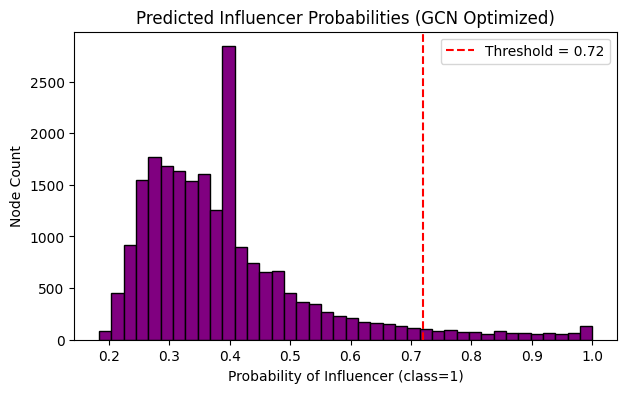

In [ ]:
# VISUALIZE INFLUENCER PROBABILITY DISTRIBUTION ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(probs, bins=40, color='purple', edgecolor='black')
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Threshold = {best_thresh:.2f}')
plt.title("Predicted Influencer Probabilities (GCN Optimized)")
plt.xlabel("Probability of Influencer (class=1)")
plt.ylabel("Node Count")
plt.legend()
plt.show()
